# 機械学習モデルのハイパーパラメータをチューニングする例

In [1]:
#化合物処理の為の関数・クラス群
from RDKitWrapper import draw_SMILES,Fingerprint,RDKitDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# データベースの読み込み (data from wikipedia)

In [2]:
df=pd.read_csv("wiki.csv")

#今回は融点を予測してみる
df=df[["SMILES","Melting temperature"]]

#抜けデータの削除
df2=df.dropna()
df2

,SMILES,Melting temperature
0,N,-77.73
1,C#C,-80.8
2,O=P(O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n2c...,187
3,OC=1C(OC(=O)C=1O)[C@@H](O)CO,190/192
4,O[C@@H]3[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]3OC[C...,223
...,...,...
1363,C1=CSC(=C1)Br,-10
1364,C(CN(CC(=O)O)CC(=O)O)C(=O)O,190/200
1365,F[Nd](F)F,1374
1368,CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N,168


In [3]:
#複数の融点がスラッシュ区切りで記録されているので、はじめのデータのみを使う

#まずはスラッシュで区切られたものを分割する
spl_y_df=df2["Melting temperature"].str.split("/", expand=True)

#1列目を代入
df2["Melting temperature"]=spl_y_df[0]
df2

C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,SMILES,Melting temperature
0,N,-77.73
1,C#C,-80.8
2,O=P(O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n2c...,187
3,OC=1C(OC(=O)C=1O)[C@@H](O)CO,190
4,O[C@@H]3[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]3OC[C...,223
...,...,...
1363,C1=CSC(=C1)Br,-10
1364,C(CN(CC(=O)O)CC(=O)O)C(=O)O,190
1365,F[Nd](F)F,1374
1368,CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N,168


# Descriptorの計算

In [4]:
#クラスを使用する為の初期化処理
desc=RDKitDescriptors()

#smilesのリストをSMILES_listに代入
SMILES_list=df2["SMILES"].values

#記述子を計算。一部の化合物でエラーが出る。
desc_list=[desc.calc(i,dict_mode=False) for i in SMILES_list]

#エラーになった化合物では記述子の配列の代わりに-1が返るので、それをもとに選別フィルターを作成
available_filter=[(False if type(i)==type(1) else True) for i in desc_list]

failed to purse:  c1[nH]c2c(n1)c(=O)nc(n2)N
please recheck SMILES
invalid smiles! c1[nH]c2c(n1)c(=O)nc(n2)N
failed to purse:  O=[Cl]=O
please recheck SMILES
invalid smiles! O=[Cl]=O
failed to purse:  [Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]
please recheck SMILES
invalid smiles! [Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]
failed to purse:  [H]1[BH]2[H][BH]3[BH]24[BH]1[H][BH]4[H]3
please recheck SMILES
invalid smiles! [H]1[BH]2[H][BH]3[BH]24[BH]1[H][BH]4[H]3
failed to purse:  [O-2]=[Ce+4]=[O-2]
please recheck SMILES
invalid smiles! [O-2]=[Ce+4]=[O-2]
failed to purse:  B1([H]3)(C2CCCC1CCC2)[H]B34C2CCCC4CCC2
please recheck SMILES
invalid smiles! B1([H]3)(C2CCCC1CCC2)[H]B34C2CCCC4CCC2
failed to purse:  FCl(F)(F)(F)F
please recheck SMILES
invalid smiles! FCl(F)(F)(F)F
failed to purse:  FBr(F)(F)(F)F
please recheck SMILES
invalid smiles! FBr(F)(F)(F)F
failed to purse:  o=c([o-])C.[N+H4]
please recheck SMILES
invalid smiles! o=c([o-])C.[N+H4]
failed to purse:  c1=cc=c[cH+]c=c1
please recheck SMILES
i

In [5]:
#エラーになっていないidのデータのみ残す
df3=df2[available_filter]

#yの設定
y=df3["Melting temperature"].values

#文字列になっているので、floatに変換
Y=np.array(y,dtype=np.float)

#scikit-learnでは、yは下記の形に変換しないと計算ができない(おまじない)
Y=Y.reshape(-1,1)
Y

array([[ -77.73],
       [ -80.8 ],
       [ 187.  ],
       ...,
       [1374.  ],
       [ 168.  ],
       [ 155.  ]])

In [6]:
#計算に失敗した記述子は削除する
X=[x for x in desc_list if type(x)!=type(1)]

#numpyに変換
X=np.array(X)


In [7]:
print(X.shape)
print(Y.shape)

(1047, 200)
(1047, 1)


# 機械学習の為の前処理

In [8]:
#融点はrangeが広いので、ケルビンスケールに変更後、logにしてしまう (ノウハウ)
log_Y=np.log10(Y+273.15)
log_Y

array([[2.29096901],
       [2.28409219],
       [2.66289943],
       ...,
       [3.21673315],
       [2.64458628],
       [2.63159595]])

In [9]:
from sklearn.model_selection import train_test_split

#10%をランダムに選んでテストデータにする。 小規模データの場合は  cross validationした方が良いが、今回は割愛
X_train, X_test, Y_train, Y_test = train_test_split(X, log_Y,test_size=0.1)

In [10]:
#平均がゼロ、標準偏差が1になるように正規化する
from sklearn.preprocessing import StandardScaler


#X
X_scaler=StandardScaler()

scaled_X_train=X_scaler.fit_transform(X_train)
scaled_X_test=X_scaler.transform(X_test)

#Y
Y_scaler=StandardScaler()

scaled_Y_train=Y_scaler.fit_transform(Y_train)
scaled_Y_test=Y_scaler.transform(Y_test)

# 機械学習

In [11]:
#プロット用のutility
from sklearn.metrics import r2_score
def auto_analysis(tr_X,tr_Y,te_X,te_Y,model):
    model.fit(tr_X,tr_Y)
    
    pred_tr_Y=model.predict(tr_X)
    pred_te_Y=model.predict(te_X)
    
    plt.scatter(tr_Y,pred_tr_Y)
    plt.scatter(te_Y,pred_te_Y)
    
    tr_r2=r2_score(tr_Y,pred_tr_Y)
    te_r2=r2_score(te_Y,pred_te_Y)
    
    print("train score: ",tr_r2)
    print("test score: ",te_r2)
    
    
    return model
    

# ハイパーパラメータの調整
- 公式マニュアルに従ってパラメータの意味を調べ、調節していく
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


train score:  0.9583827572037464
test score:  0.47386314542271546


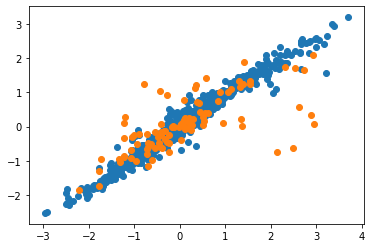

In [12]:
#random forest
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)


train score:  0.6587510282330742
test score:  0.30386178102516836


C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


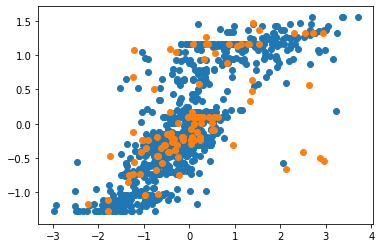

In [13]:
#random forestの主なハイパーパラメータはn_estimators,max_depth

#手作業で値を変えてみる
model=RandomForestRegressor(n_estimators=10,max_depth=3)
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)


In [14]:
import warnings
warnings.simplefilter('ignore')

#r2を計算するためのユーティリティ関数
def get_r2_test(tr_X,tr_Y,te_X,te_Y,model):
    model.fit(tr_X,tr_Y)
    
    pred_tr_Y=model.predict(tr_X)
    pred_te_Y=model.predict(te_X)
    
    te_r2=r2_score(te_Y,pred_te_Y)
    return te_r2

In [15]:
#グリッドサーチ
best_score=0
for n in [5,10,50,100]:
    for dep in [3,5,10]:
        model=RandomForestRegressor(n_estimators=n,max_depth=dep)
        score=get_r2_test(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)
        print(n,dep,score)
        
        if score>best_score:
            best_score=score
            best_cond=[n,dep]

print("best: ",best_score,best_cond)

5 3 0.28239330579912847
5 5 0.3733105296894501
5 10 0.35176930692789543
10 3 0.2814557129187555
10 5 0.4024747005834488
10 10 0.4595718929991558
50 3 0.30435155527952973
50 5 0.4139887008648464
50 10 0.48432261002230603
100 3 0.29479124097523635
100 5 0.3934097115138868
100 10 0.5008869827570226
best:  0.5008869827570226 [100, 10]


In [16]:
#ランダムサーチ

import random

best_score=0
for i in range(10):
    n=random.randint(1,200)
    dep=random.randint(1,20)
    
    model=RandomForestRegressor(n_estimators=n,max_depth=dep)
    score=get_r2_test(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)
    print(n,dep,score)

    if score>best_score:
        best_score=score
        best_cond=[n,dep]
        
print("best: ",best_score,best_cond)

168 2 0.23563803181268073
193 19 0.4998685224523254
51 9 0.4517109313799239
38 14 0.46982332527600634
106 1 0.17607249454878382
7 19 0.5404670069424233
53 19 0.4849451877303286
153 4 0.3603819040135682
197 13 0.48217524888495245
94 4 0.35075313035266653
best:  0.5404670069424233 [7, 19]


In [17]:
#ベイズ最適化
#GPyOptをインストールすること

import GPyOpt

#ユーティリティ関数
def f(x):
    n,dep = int(x[:,0]),int(x[:,1])
    model=RandomForestRegressor(n_estimators=n,max_depth=dep)
    score=get_r2_test(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)
    
    return -score

bounds = [{'name': 'n', 'type': 'discrete', 'domain': range(1,100)},
         {'name': 'dep', 'type': 'discrete', 'domain': range(1,20)}
         ]
myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,initial_design_numdata=3)

In [18]:
myBopt.run_optimization(max_iter=10,verbosity=1)
print("condition: ",myBopt.x_opt)
print("best score" ,-myBopt.fx_opt)

num acquisition: 1, time elapsed: 1.29s
num acquisition: 2, time elapsed: 1.80s
num acquisition: 3, time elapsed: 3.08s
num acquisition: 4, time elapsed: 4.56s
num acquisition: 5, time elapsed: 5.51s
num acquisition: 6, time elapsed: 6.92s
num acquisition: 7, time elapsed: 7.61s
num acquisition: 8, time elapsed: 9.33s
num acquisition: 9, time elapsed: 11.26s
num acquisition: 10, time elapsed: 13.11s
condition:  [59. 19.]
best score 0.5097671942051618
